In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from keras import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras import backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder
from keras import regularizers as reg


Using TensorFlow backend.


a. Carga de Datos

Hay 3500 datos para entrenamiento y 1050 para test.

In [2]:
mat_train = sio.loadmat('AgeGenderClassification/eventrain.mat')
mat_test = sio.loadmat('AgeGenderClassification/eventest.mat')

In [3]:
data_test = mat_test['tecoll'][0][0]
data_train = mat_train['trcoll'][0][0]

In [4]:
len(data_test[0])

1050

In [5]:
len(data_train[0])

3500

b. Selección de representación

Se seleccionaron los siguientes datos para entrenar:

#genFeat = data_train[0]            Características de las imagenes
#ageClass = data_train[1]           Edad
#genClass = data_train[2]           Género
#ffcoefs = data_train[3]            Fisherface, reconocimiento de luz y expresiones
#faceGist = data_train[4]           Gesto

In [7]:
X_train=pd.DataFrame(np.float64(data_train[2]))

In [8]:
#Caracteristicas del FisherFace
ffc=data_train[3]
for i in range(len(ffc[0])):
    X_train['ffc'+str(i)]=np.float64(ffc[:,i])

#Caraceristicas del Gesto
fcg=data_train[4]
for i in range(len(fcg[0])):
    X_train['fcg'+str(i)]=np.float64(fcg[:,i])

#Caraceristicas de la imagen
fim=data_train[0]
for i in range(len(fim[0])):
    X_train['fim'+str(i)]=np.float64(fim[:,i])

In [9]:
X_test=pd.DataFrame(np.float64(data_test[2]))

In [10]:
#Caracteristicas del FisherFace
ffc=data_test[3]
for i in range(len(ffc[0])):
    X_test['ffc'+str(i)]=np.float64(ffc[:,i])

#Caraceristicas del Gesto
fcg=data_test[4]
for i in range(len(fcg[0])):
    X_test['fcg'+str(i)]=np.float64(fcg[:,i])

#Caraceristicas de la imagen
fim=data_test[0]
for i in range(len(fim[0])):
    X_test['fim'+str(i)]=np.float64(fim[:,i])

In [11]:
scaler_x=StandardScaler().fit(X_train)

In [12]:
X_train_scaled=pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
X_test_scaled=pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)
X_val_scaled=X_test_scaled
#X_val_scaled=X_train_scaled[0:500]
#X_train_scaled=X_train_scaled[500:]

In [13]:
#scaler_y=StandardScaler().fit(y_train)

In [14]:
y_train=pd.DataFrame(np.float64(data_train[1])) #Edad
y_test=pd.DataFrame(np.float64(data_test[1])) #Edad

label_encoder1 = LabelEncoder()
y_train = label_encoder1.fit_transform(y_train)
y_train_c=keras.utils.to_categorical(y_train, num_classes=7)
label_encoder2 = LabelEncoder()
y_test = label_encoder2.fit_transform(y_test)
y_test_c=keras.utils.to_categorical(y_test, num_classes=7)
y_val_c = y_test_c


/home/rohermosilla/.conda/envs/redesneuronales/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
def plot_chart(history):
    plt.rcParams["figure.figsize"] = [12,4]
    subtitle=''
    global n_test
    n_test=1
    var_activation=''
    train_loss=history.history['loss']
    test_loss=history.history['val_loss']
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.plot(test_loss)
    n_test=n_test+1
    plt.title('MODEL LOSS, test #'+str(n_test)+'\n'+
              str.capitalize(var_activation)+', '+subtitle)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    min_v=0
    max_v=np.max(train_loss)
    plt.title('TRAIN VS TEST, test #'+str(n_test)+'\n'+
              str.capitalize(var_activation)+', '+subtitle)
    plt.xlabel('train')
    plt.ylabel('test')
    plt.grid()
    plt.plot([0,max_v], [0,max_v], color='red', linewidth=0.5)
    plt.scatter(train_loss,test_loss)
    plt.xlim(0,max_v)
    plt.ylim(0,max_v)
    plt.show()

In [73]:
def convert_to_output(df):
    df=df.replace(6,75)
    df=df.replace(5,51)
    df=df.replace(4,25)
    df=df.replace(3,16)
    df=df.replace(2,10)
    df=df.replace(1,5)
    df=df.replace(0,1)
    return df

In [74]:
def get_mce(predict):
    n=len(y_test)
    df_yt = pd.DataFrame(y_test)
    df_yt = convert_to_output(df_yt)
    df_pr=pd.DataFrame(np.argmax(np.around(predict),axis=-1))
    df_pr = convert_to_output(df_pr)
    mce_individual = pow(df_pr-df_yt,2)
    output=pd.DataFrame()
    output['y']=df_yt[0]
    output['pr']=df_pr
    output['diff']=mce_individual
    aciertos=len(output[output['diff']==0])
    print('Aciertos: '+str(aciertos)+' de '+str(n)+' ('+str(round(aciertos*100/n,2))+')%')
    output.to_excel('salida.xlsx')
    print(output.head())
    total = np.sum(mce_individual[0])/n 
    return(total)

C. Modelo y entrenamiento.

El modelo se entreno con la siguiente configuración,resaltando que no se logro el objetivo de MSE menor a 100 exigido por la tarea, la mejor tasa de aciertos fue del 42%

In [101]:
def define_model():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global sgd
    model = Sequential()
    n_nodes=300
    model.add(Dense(n_nodes, input_dim=X_train_scaled.shape[1],kernel_initializer='he_uniform',
            activation='relu', kernel_regularizer=reg.l2(0.1)))
    model.add(Dense(n_nodes, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_nodes, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_nodes, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_nodes, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_nodes, kernel_initializer='he_uniform', activation='linear'))
    model.add(Dense(7, kernel_initializer='he_uniform', activation='softmax'))
    opt = SGD(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy')
    return (model)

In [102]:
def train_model(model):
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_c
    global y_val_c
    history = model.fit(
        X_train_scaled,
        y_train_c,
        epochs=50,
        verbose=0,
        batch_size=150,
        validation_data=(X_val_scaled, y_val_c))
    return (history)

In [103]:
model=define_model()

In [104]:
history=train_model(model)

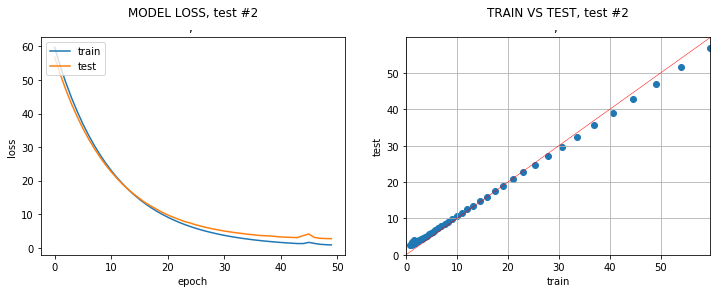

In [105]:
plot_chart(history)

In [106]:
predict=model.predict(X_test_scaled)

In [107]:
pd.DataFrame(predict).head()

,0,1,2,3,4,5,6
0,0.000555,0.000030,0.000026,0.003818,0.020090,0.059313,0.916168
1,0.000082,0.000730,0.009198,0.023646,0.432255,0.200422,0.333667
2,0.000025,0.000046,0.000291,0.065856,0.899454,0.033162,0.001166
3,0.060473,0.025072,0.296372,0.116515,0.031612,0.280646,0.189310
4,0.000202,0.000303,0.012163,0.053485,0.158204,0.773615,0.002028


In [108]:
pd.DataFrame(y_test_c).head()

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [109]:
print("MCE: "+str(get_mce(predict)))

Aciertos: 431 de 1050 (41.05)%
    y  pr  diff
0  25  75  2500
1  25   1   576
2  25  25     0
3  25   1   576
4  25  51   676
MCE: 490.78
